In [1]:
import os
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import geodatasets

In [2]:
# Getting the list of csv before importing them 
path = 'dvfplus-selected/DVF_PLUS_2025_2_CSV_R999_ED251/1_DONNEES_LIVRAISON'
os.chdir(path)
files = os.listdir()

Refer to this link for precise explanation of the variables: https://doc-datafoncier.cerema.fr/doc/dv3f/mutation

In [3]:
# Importing all the csv and concatening them
# Can take some times
df = pd.concat((pd.read_csv(file,sep='|') for file in files),ignore_index=True)

/var/folders/h_/8kpmh0nd0qqdmdc_k6x_pfrm0000gn/T/ipykernel_94114/3184738901.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat((pd.read_csv(file,sep='|') for file in files),ignore_index=True)


Se reporter à cette documentation pour l'explication des variables : https://doc-datafoncier.cerema.fr/doc/dv3f/mutation. La plupart sont inutiles pour le projet.

# Dictionnaire des variables - Jeu de données DV3F (Cerema)

Ce jeu de données est issu des **Demandes de Valeurs Foncières (DVF)** retraitées par le **Cerema**. Il recense les mutations immobilières à titre onéreux (ventes, échanges, adjudications).

## 1. Identifiants et Références
Ces clés permettent l'unicité de la ligne ou la jointure avec d'autres tables (Fichiers Fonciers / Majic).

| Colonne | Description |
| :--- | :--- |
| **`idmutation`** | Identifiant unique de la transaction (généré par le Cerema). |
| `idmutinvar` | Identifiant stable pour joindre avec les Fichiers Fonciers (Majic). |
| `idopendata` | Identifiant d'origine dans le fichier DVF brut (DGFiP). |
| `codservch` | Code du Service de la Publicité Foncière (SPF). |
| `refdoc` | Référence de publication (Volume / Numéro). |

## 2. Date et Nature de la Transaction

| Colonne | Description |
| :--- | :--- |
| **`datemut`** | Date précise de la mutation. |
| `anneemut` | Année de la mutation. |
| `moismut` | Mois de la mutation. |
| `idnatmut` | Code de la nature de la mutation (1 = Vente, etc.). |
| **`libnatmut`** | Libellé de la nature (ex: "Vente", "Vente en l'état futur d'achèvement"). |
| **`vefa`** | Indicateur (Vrai/Faux) : Vente en l'État Futur d'Achèvement (neuf). |
| `nbartcgi` | Nombre d'articles du CGI (régime fiscal). |
| `l_artcgi` | Liste des codes articles du CGI. |
| `nbdispo` | Nombre de dispositions dans l'acte. |

## 3. Localisation Géographique

| Colonne | Description |
| :--- | :--- |
| `coddep` | Code département (ex: 75, 59). |
| `nbcomm` | Nombre de communes concernées. |
| `l_codinsee` | Liste des codes INSEE des communes. |
| `nbsection` / `l_section` | Nombre et liste des sections cadastrales. |
| `nbpar` / `l_idpar` | Nombre et liste des identifiants de parcelles concernées. |
| `nbparmut` / `l_idparmut` | Nombre et liste des parcelles **réellement mutées**. |
| `geompar_x` / `geompar_y` | Coordonnées géographiques (centroïdes). |

## 4. Prix et Foncier (Terrain)

| Colonne | Description |
| :--- | :--- |
| **`valeurfonc`** | **Montant global de la transaction** (Net Vendeur). *Somme pour tous les biens de la mutation.* |
| `sterr` | Surface totale du terrain en m². |
| `l_dcnt` | Liste des contenances (surfaces) cadastrales. |
| `nbsuf` | Nombre de surfaces (lien Fichiers Fonciers). |

## 5. Caractéristiques du Bâti (Général)

| Colonne | Description |
| :--- | :--- |
| `codtypbien` | Code typologie du bien (calculé par le Cerema). |
| **`libtypbien`** | Libellé typologie (ex: "Maison", "Appartement ancien", "Terrain à bâtir"). |
| **`sbati`** | Surface bâtie totale (m²) de tous les locaux. |
| `nblot` | Nombre de lots de copropriété. |
| `nbvolmut` | Nombre de volumes mutés. |
| `nblocmut` | Nombre total de locaux mutés. |
| `l_idlocmut` | Liste des identifiants des locaux. |

## 6. Détail par Type de Local
Répartition des locaux par catégorie et surfaces associées.

| Colonne (Nombre) | Colonne (Surface) | Description |
| :--- | :--- | :--- |
| `nblocmai` | `sbatmai` | Nombre et surface bâtie des **Maisons**. |
| `nblocapt` | `sbatapt` | Nombre et surface bâtie des **Appartements**. |
| `nblocact` | `sbatact` | Nombre et surface bâtie des **Locaux d'activité**. |
| `nblocdep` | - | Nombre de **Dépendances** isolées. |

## 7. Détail des Pièces (Logements)
Détail par nombre de pièces principales (PP).
*Note : `5pp` correspond à "5 pièces et plus".*

| Type | Compteurs (Nombre) | Surfaces (m²) |
| :--- | :--- | :--- |
| **Appartements** | `nbapt1pp` à `nbapt5pp` | `sapt1pp` à `sapt5pp` |
| **Maisons** | `nbmai1pp` à `nbmai5pp` | `smai1pp` à `smai5pp` |

---
> ** Note Importante pour l'analyse :**
> La colonne **`valeurfonc`** représente la valeur totale de la mutation (`idmutation`). Si une ligne contient plusieurs biens (ex: un immeuble avec `nblocapt` = 10), la valeur foncière est le prix global de l'immeuble, et non le prix par appartement.

In [4]:
df.columns

Index(['idmutation', 'idmutinvar', 'idopendata', 'idnatmut', 'codservch',
       'refdoc', 'datemut', 'anneemut', 'moismut', 'coddep', 'libnatmut',
       'nbartcgi', 'l_artcgi', 'vefa', 'valeurfonc', 'nbdispo', 'nblot',
       'nbcomm', 'l_codinsee', 'nbsection', 'l_section', 'nbpar', 'l_idpar',
       'nbparmut', 'l_idparmut', 'nbsuf', 'sterr', 'l_dcnt', 'nbvolmut',
       'nblocmut', 'l_idlocmut', 'nblocmai', 'nblocapt', 'nblocdep',
       'nblocact', 'nbapt1pp', 'nbapt2pp', 'nbapt3pp', 'nbapt4pp', 'nbapt5pp',
       'nbmai1pp', 'nbmai2pp', 'nbmai3pp', 'nbmai4pp', 'nbmai5pp', 'sbati',
       'sbatmai', 'sbatapt', 'sbatact', 'sapt1pp', 'sapt2pp', 'sapt3pp',
       'sapt4pp', 'sapt5pp', 'smai1pp', 'smai2pp', 'smai3pp', 'smai4pp',
       'smai5pp', 'codtypbien', 'libtypbien', 'geompar_x', 'geompar_y'],
      dtype='object')

In [4]:
relev_cols=['anneemut','datemut','valeurfonc','coddep','sbati','sterr','geompar_x','geompar_y','libtypbien']

In [5]:
df_reduced = df[relev_cols]

In [7]:
#Checking for na values and non-relevant ones (0 and 1€ transactions)
print(df_reduced['valeurfonc'].loc[df_reduced['valeurfonc']==1].count()) 
print(df_reduced['valeurfonc'].loc[df_reduced['valeurfonc']==0].count())
print(df_reduced['valeurfonc'].loc[df_reduced['valeurfonc'].isna()].count())

102501
5288
0


In [6]:
# Following previous anaylysis, we clean the data 

# Removing irrelevant transactions based on price
view = df_reduced.loc[:,'valeurfonc']
filter = (view==0) | (view==1)  | (view.isna())
df_cleaned = df_reduced.loc[~filter]


In [30]:
df_reduced.loc[df_reduced['valeurfonc']==14149999600.0]

,anneemut,datemut,valeurfonc,coddep,sbati,sterr,geompar_x,geompar_y
8906889,2021,2021-10-14,1.415000e+10,13,4324.0,5484.0,893374.915616,6.243404e+06


In [9]:
# We check the other columns 
for col in relev_cols:
    print(df_cleaned[col].loc[df_cleaned[col].isna()].count())

0
0
0
0
0
0
0
0


In [10]:
# We check for weird case that could happen else than na values
print(df_cleaned['anneemut'].min(),df_cleaned['anneemut'].max()) #Checking the range of years
print(df_cleaned['datemut'].min(),df_cleaned['datemut'].max()) #Checking concistency with years
print(df_cleaned['valeurfonc'].min(),df_cleaned['valeurfonc'].max()) #Checking range of prices
print(df_cleaned['sbati'].min(),df_cleaned['sbati'].max()) #Checkin range of surfaces
print(df_cleaned['sterr'].min(),df_cleaned['sterr'].max())

2014 2025
2014-01-01 2025-06-30
0.01 14149999600.0
0.0 877926.0
0.0 35055638.0


In [11]:
df_cleaned['coddep'].unique() # Checking coherent dep codes

array([79, 51, 45, 92, 86, 87, 93, 44, 50, 78, 46, 52, 85, 91, 90, 84, 53,
       47, 43, 80, 94, 95, 81, 56, 42, 54, 40, 83, 82, 69, 41, 55, 32, 26,
       27, 33, '2A', 19, 25, 31, 30, 24, 18, '2B', 34, 8, 9, 35, 21, 37,
       23, 22, 36, 13, 7, 6, 12, 38, 4, 10, 11, 5, 39, 1, 15, 29, 28, 14,
       16, 2, 3, 17, 58, 70, 64, 972, 973, 65, 71, 59, 73, 971, 72, 66,
       62, 76, 89, 974, 88, 77, 63, 75, 61, 49, 48, 60, 74], dtype=object)

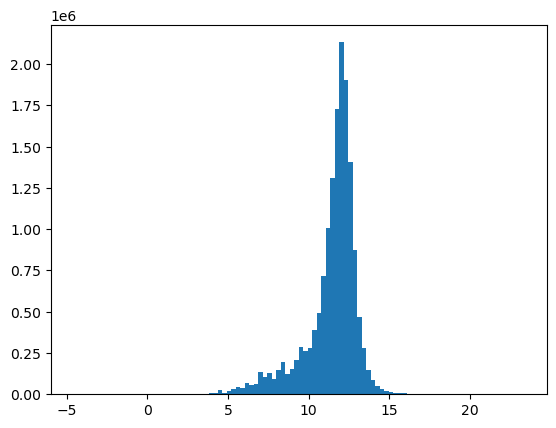

In [25]:
# Creating bins with numpy for faster computations
counts, bin_edges = np.histogram(np.log(df_cleaned['valeurfonc']), bins=100)

# We look at a barplot of the log of valeurfonc to have an idea of the values
plt.bar(bin_edges[:-1], counts, width=np.diff(bin_edges), align='edge')
plt.show()

In [7]:
# Since valeurfonc is highly dependant on the size of the building/house sold, we look at price/m2
# We choose to divide first by the built surface (other approches to come)
df_cleaned['p/m2']=df_cleaned['valeurfonc']/df_cleaned['sbati']

/var/folders/h_/8kpmh0nd0qqdmdc_k6x_pfrm0000gn/T/ipykernel_94114/1918048244.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['p/m2']=df_cleaned['valeurfonc']/df_cleaned['sbati']


In [ ]:
# Voir comment utiliser
df_cleaned['libtypbien'].unique()

array(['UNE MAISON', 'TERRAIN DE TYPE TERRE ET PRE',
       'TERRAIN DE TYPE TAB', 'UN APPARTEMENT',
       'TERRAIN NON BATIS INDETERMINE', 'TERRAIN LANDES ET EAUX',
       'TERRAIN FORESTIER', 'DES MAISONS', 'TERRAIN ARTIFICIALISE MIXTE',
       'BATI - INDETERMINE : Vefa sans descriptif', 'ACTIVITE',
       'TERRAIN VITICOLE', 'DES DEPENDANCES', 'BATI MIXTE - LOGEMENTS',
       'BATI - INDETERMINE : Vente avec volume(s)',
       'BATI MIXTE - LOGEMENT/ACTIVITE', "TERRAIN D'AGREMENT",
       'UNE DEPENDANCE', 'APPARTEMENT INDETERMINE',
       'TERRAIN AGRICOLE MIXTE', 'DEUX APPARTEMENTS', 'TERRAIN VERGER',
       "TERRAIN D'EXTRACTION", 'TERRAIN DE TYPE RESEAU',
       'TERRAIN NATUREL MIXTE', 'MAISON - INDETERMINEE'], dtype=object)

In [9]:
# Geopandas
gdf = gpd.GeoDataFrame(
    df_cleaned, 
    geometry=gpd.points_from_xy(df_cleaned['geompar_x'], df_cleaned['geompar_y']),
    crs = "EPSG:2154"
)
gdf = gdf.to_crs("EPSG:4326")


In [10]:
gdf.sample(1000).explore()

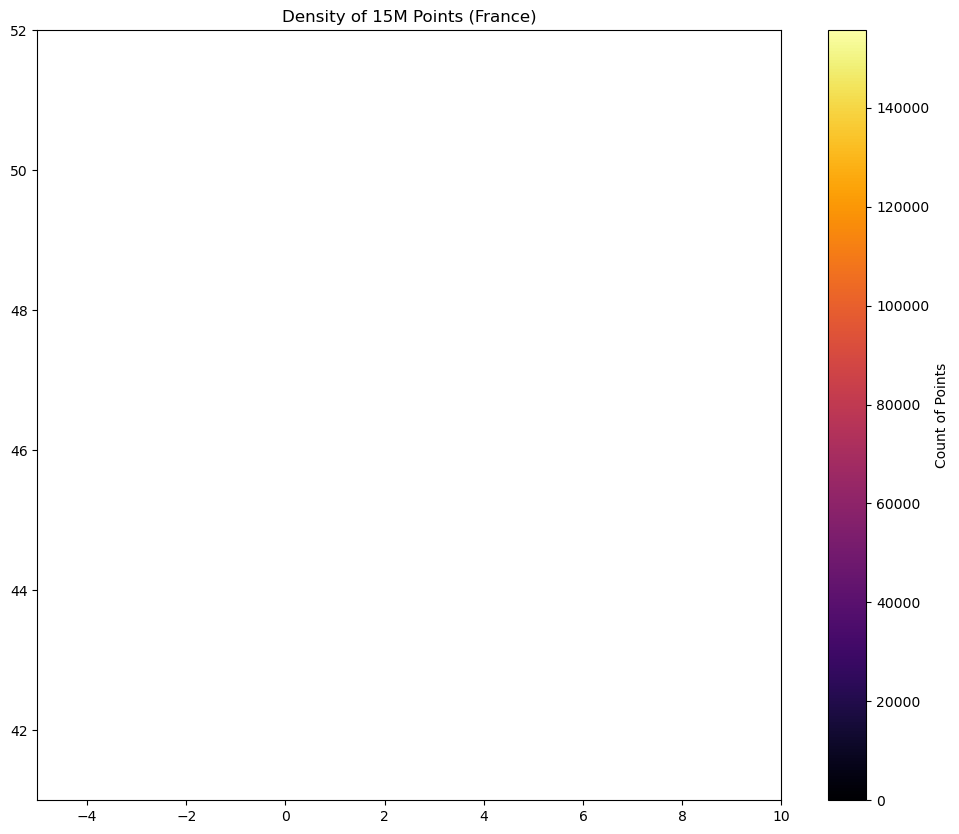

In [33]:
# Setup the figure
fig, ax = plt.subplots(figsize=(12, 10))

# Create a hexbin map
# gridsize: controls resolution (higher = smaller hexagons)
# cmap: color scheme (e.g., 'inferno', 'viridis', 'plasma')
# mincnt=1: hides empty background hexagons
hb = ax.hexbin(
    df_cleaned['geompar_x'], 
    df_cleaned['geompar_y'], 
    gridsize=500,  
    cmap='inferno'
)

# Add a colorbar to show the scale
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Count of Points')

# Center on France
ax.set_xlim([-5, 10])
ax.set_ylim([41, 52])

plt.title("Density of 15M Points (France)")
plt.show()

In [36]:
# 1. Get the world map
world = gpd.read_file(geodatasets.get_path('naturalearth_lowres'))

# 2. Setup the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# 3. Plot the world map first (as the background)
world.plot(ax=ax, color='lightgrey', edgecolor='white')

# 4. Plot your data on the same axis (ax=ax)
# You can use column='Value' to color points by data, and legend=True to show the scale
gdf.sample(1000).plot(ax=ax, color='red', markersize=50, alpha=0.7)

plt.title("My Data on a Map")
plt.show()

ValueError: No matching item found for the query 'naturalearth_lowres'.